In [58]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import lars_path, LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import requests, io, re

from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [59]:
# Import data
data_mar = pd.read_csv("/Users/galamboslajos/Desktop/Amsterdam_HW2/listings_amsterdam_FINAL_MARCH.csv")
data_mar.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,...,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ln_price,property_House,property_Private room,property_Shared Room
0,100%,100%,t,1,1,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,...,0363 5F3A 5684 6750 D14D,1,0,1,0,1.90,4.234107,False,True,False
1,100%,68%,f,1,1,"['email', 'phone', 'work_email']",t,f,"Amsterdam, North Holland, Netherlands",Centrum-West,...,0363 59D8 7D30 6CFA DC81,1,1,0,0,0.66,5.783825,True,False,False
2,93%,89%,t,2,3,"['email', 'phone']",t,t,"De Pijp, North Holland, Netherlands",De Pijp - Rivierenbuurt,...,0363 7D88 E1E8 F521 9A10,2,1,1,0,3.73,5.497168,True,False,False
3,100%,100%,f,3,4,['phone'],t,t,"Amsterdam, North Holland, Netherlands",De Pijp - Rivierenbuurt,...,0363 8A88 B129 62B5 BD4E,2,0,2,0,4.19,5.497168,False,True,False
4,NaN,NaN,f,1,1,"['email', 'phone']",t,t,NaN,De Baarsjes - Oud-West,...,0363 A942 21DC C431 1AD1,1,1,0,0,0.24,5.393628,True,False,False


In [60]:
columns_to_drop = ['host_verifications', 'latitude', 'longitude', 'host_listings_count',
                   'host_total_listings_count', 'maximum_nights_avg_ntm', 'minimum_minimum_nights', 'calendar_last_scraped',
                   'first_review']

data_mar.drop(columns_to_drop, axis=1, inplace=True)

In [61]:
# Formatting columns    
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
]:
    data_mar[binary] = data_mar[binary].map({"t": True, "f": False})

data_mar["f_property_type"] = data_mar["property_type"].astype("category")
data_mar["f_neighbourhood_cleansed"] = data_mar["neighbourhood_cleansed"].astype("category")
data_mar['n_bathroom'] = data_mar['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
data_mar['host_acceptance_rate'] = data_mar['host_acceptance_rate'].str.replace('%', '').astype(float)
data_mar['host_response_rate'] = data_mar['host_response_rate'].str.replace('%', '').astype(float)

In [62]:
import re
from collections import Counter

# Loop through each row in the 'amenities' column
all_amenities = []

for row in data_mar['amenities']:
    # Remove leading and trailing brackets and then split into a list
    amenities_list = [re.sub(r'[^\w\s]', '', amenity.strip(' "')) for amenity in row.strip('][').split(', ')]
    all_amenities.extend(amenities_list)

# Count occurrences of each amenity
amenities_counter = Counter(all_amenities)

# Select the top 150 most frequent amenities
top_150_amenities = [amenity for amenity, _ in amenities_counter.most_common(150)]
for amenity in top_150_amenities:
    data_mar[f'd_{amenity}'] = data_mar['amenities'].apply(lambda x: 1 if amenity in x else 0)

# List columns to drop
columns_to_drop = [col for col in data_mar.columns if col.startswith('d_') and col not in [f'd_{amenity}' for amenity in top_150_amenities]]

# Drop columns
data_mar.drop(columns=columns_to_drop, inplace=True)

# Rename columns by replacing spaces with underscores
columns_to_rename = [col for col in data_mar.columns if col.startswith('d_')]
for col in columns_to_rename:
    new_col_name = col.replace(' ', '_')
    data_mar.rename(columns={col: new_col_name}, inplace=True)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [63]:
top_150_amenities

['Smoke alarm',
 'Essentials',
 'Wifi',
 'Kitchen',
 'Hot water',
 'Dishes and silverware',
 'Hair dryer',
 'Hangers',
 'Refrigerator',
 'Iron',
 'Heating',
 'Bed linens',
 'Cooking basics',
 'Shampoo',
 'Carbon monoxide alarm',
 'Washer',
 'Dishwasher',
 'Fire extinguisher',
 'Coffee maker',
 'Dedicated workspace',
 'First aid kit',
 'Microwave',
 'Private entrance',
 'Oven',
 'TV',
 'Cleaning products',
 'Extra pillows and blankets',
 'Wine glasses',
 'Dining table',
 'Hot water kettle',
 'Stove',
 'Shower gel',
 'Freezer',
 'Private patio or balcony',
 'Host greets you',
 'Luggage dropoff allowed',
 'Coffee',
 'Drying rack for clothing',
 'Outdoor furniture',
 'Body soap',
 'Roomdarkening shades',
 'Dryer',
 'Outdoor dining area',
 'Central heating',
 'Bathtub',
 'Long term stays allowed',
 'Paid parking off premises',
 'Laundromat nearby',
 'Self checkin',
 'Toaster',
 'Free washer u2013 In unit',
 'Books and reading material',
 'TV with standard cable',
 'Portable fans',
 'Free dr

In [64]:
data_mar

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,...,d_Smart_lock,d_Nespresso,d_River_view,d_Apple_TV,d_Stainless_steel_gas_stove,d_Resort_access,d_HDTV_with_Chromecast,d_yoga_mat,d_Childrenu2019s_books_and_toys_for_ages_02_years_old,d_Amazon_Prime_Video
0,100.0,100.0,True,True,True,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,Private room,2,1.5 shared baths,...,0,0,0,0,0,0,0,1,0,0
1,100.0,68.0,False,True,False,"Amsterdam, North Holland, Netherlands",Centrum-West,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
2,93.0,89.0,True,True,True,"De Pijp, North Holland, Netherlands",De Pijp - Rivierenbuurt,House,4,1 bath,...,0,1,0,0,0,0,0,0,0,0
3,100.0,100.0,False,True,True,"Amsterdam, North Holland, Netherlands",De Pijp - Rivierenbuurt,Private room,4,1.5 baths,...,0,1,0,1,0,0,0,0,0,0
4,NaN,NaN,False,True,True,NaN,De Baarsjes - Oud-West,House,4,1 bath,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6754,NaN,NaN,False,True,True,"Amsterdam, Noord-Holland, Netherlands",De Pijp - Rivierenbuurt,House,2,1.5 baths,...,0,0,0,0,0,0,0,0,0,0
6755,NaN,NaN,False,True,True,"Amsterdam, Noord-Holland, Netherlands",Centrum-Oost,House,2,1 bath,...,0,1,0,0,0,0,0,0,0,0
6756,NaN,NaN,False,True,True,NaN,Oud-Noord,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
6757,NaN,NaN,False,True,True,NaN,Watergraafsmeer,House,4,1 bath,...,0,0,0,0,0,0,0,0,0,0


In [65]:
numericals = [
    "accommodates",
    "availability_365",
    "review_scores_value",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "review_scores_location",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_cleanliness",
    "reviews_per_month",
    "minimum_nights",
    "maximum_nights",
    "beds",
    "bedrooms",
    "host_acceptance_rate",
    "host_response_rate",
]

for col in numericals:
    data_mar["n_" + col] = pd.to_numeric(data_mar[col], errors="coerce")

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [66]:
data_mar["n_review_scores_value"].fillna(data_mar["n_review_scores_value"].mean(), inplace=True)
data_mar["n_review_scores_location"].fillna(data_mar["n_review_scores_location"].mean(), inplace=True)
data_mar["n_review_scores_communication"].fillna(data_mar["n_review_scores_communication"].mean(), inplace=True)
data_mar["n_review_scores_checkin"].fillna(data_mar["n_review_scores_checkin"].mean(), inplace=True)
data_mar["n_reviews_per_month"].fillna(data_mar["n_reviews_per_month"].mean(), inplace=True)
data_mar["n_bedrooms"].fillna(data_mar["n_bedrooms"].mean(), inplace=True)
data_mar["n_host_acceptance_rate"].fillna(data_mar["n_host_acceptance_rate"].mean(), inplace=True)
data_mar["n_host_response_rate"].fillna(data_mar["n_host_response_rate"].mean(), inplace=True)

data_mar = data_mar.assign(
    flag_review_scores_value=np.multiply(data_mar.n_review_scores_value.isna(), 1),
    n_review_scores_value=data_mar.n_review_scores_value.fillna(
        np.mean(data_mar.n_review_scores_value.dropna())
    ),
    flag_review_scores_location=np.multiply(data_mar.n_review_scores_location.isna(), 1),
    n_review_scores_location=data_mar.n_review_scores_location.fillna(
        np.mean(data_mar.n_review_scores_location.dropna())
    ),

    flag_review_scores_communication=np.multiply(data_mar.n_review_scores_communication.isna(), 1),
    n_review_scores_communication=data_mar.n_review_scores_communication.fillna(
        np.mean(data_mar.n_review_scores_communication.dropna())
    ),

    flag_review_scores_checkin=np.multiply(data_mar.n_review_scores_checkin.isna(), 1),
    n_review_scores_checkin=data_mar.n_review_scores_checkin.fillna(
        np.mean(data_mar.n_review_scores_checkin.dropna())
    ),

    flag_reviews_per_month=np.multiply(data_mar.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=data_mar.n_reviews_per_month.fillna(
        np.mean(data_mar.n_reviews_per_month.dropna())
    ),

    flag_review_scores_cleanliness=np.multiply(data_mar.n_review_scores_cleanliness.isna(), 1),
    n_review_scores_cleanliness=data_mar.n_review_scores_cleanliness.fillna(
        np.mean(data_mar.n_review_scores_cleanliness.dropna())
    ),
    flag_bedrooms=np.multiply(data_mar.n_bedrooms.isna(), 1),
    n_bedrooms=data_mar.n_bedrooms.fillna(
        np.mean(data_mar.n_bedrooms.dropna())
    ),
    flag_host_acceptance_rate=np.multiply(data_mar.host_acceptance_rate.isna(), 1),
    n_host_acceptance_rate=data_mar.host_acceptance_rate.fillna(
        np.mean(data_mar.host_acceptance_rate.dropna())
    ),
    flag_host_response_rate=np.multiply(data_mar.host_response_rate.isna(), 1),
    n_host_response_rate=data_mar.host_response_rate.fillna(
        np.mean(data_mar.host_response_rate.dropna())
    ),
)

In [67]:
columns_to_check = ['n_bathroom', 'n_beds', 'host_has_profile_pic']
data_mar.dropna(subset=columns_to_check, inplace=True)

In [68]:
mean_acceptance_rate = data_mar['host_acceptance_rate'].mean()
data_mar['host_acceptance_rate'].fillna(mean_acceptance_rate, inplace=True)
mean_response_rate = data_mar['host_response_rate'].mean()
data_mar['host_response_rate'].fillna(mean_response_rate, inplace=True)
mean_bedroom = data_mar['bedrooms'].mean()
data_mar['bedrooms'].fillna(mean_bedroom, inplace=True)
data_mar.dropna(subset=['host_is_superhost'], inplace=True)

In [69]:
missing_values = data_mar.isnull().sum()
missing_values

host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_has_profile_pic              0
host_identity_verified            0
                                 ..
flag_reviews_per_month            0
flag_review_scores_cleanliness    0
flag_bedrooms                     0
flag_host_acceptance_rate         0
flag_host_response_rate           0
Length: 217, dtype: int64

In [70]:
data_mar.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,...,n_host_response_rate,flag_review_scores_value,flag_review_scores_location,flag_review_scores_communication,flag_review_scores_checkin,flag_reviews_per_month,flag_review_scores_cleanliness,flag_bedrooms,flag_host_acceptance_rate,flag_host_response_rate
0,100.000000,100.000000,True,True,True,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,Private room,2,1.5 shared baths,...,100.000000,0,0,0,0,0,0,0,0,0
1,100.000000,68.000000,False,True,False,"Amsterdam, North Holland, Netherlands",Centrum-West,House,2,1 bath,...,100.000000,0,0,0,0,0,0,0,0,0
2,93.000000,89.000000,True,True,True,"De Pijp, North Holland, Netherlands",De Pijp - Rivierenbuurt,House,4,1 bath,...,93.000000,0,0,0,0,0,0,0,0,0
3,100.000000,100.000000,False,True,True,"Amsterdam, North Holland, Netherlands",De Pijp - Rivierenbuurt,Private room,4,1.5 baths,...,100.000000,0,0,0,0,0,0,0,0,0
4,94.988328,79.255308,False,True,True,NaN,De Baarsjes - Oud-West,House,4,1 bath,...,94.942845,0,0,0,0,0,0,0,1,1


In [71]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_bedrooms",
    "n_bathroom",
    "n_beds",
    #"f_neighbourhood_cleansed",
    "n_availability_365",
    "n_minimum_nights",
    "n_maximum_nights",
    "host_is_superhost",
    "n_host_acceptance_rate",
    "host_has_profile_pic",
    "n_host_response_rate",
]

# reviews
reviews = [
    "n_review_scores_value",
    "flag_review_scores_value",
    "n_review_scores_location",
    "flag_review_scores_location",
    "n_review_scores_communication",
    "flag_review_scores_communication",
    "n_review_scores_checkin",
    "flag_review_scores_checkin",
    "n_review_scores_cleanliness",
    "flag_review_scores_cleanliness",
    "n_reviews_per_month",
    "flag_reviews_per_month"
]

amenities = [col for col in data_mar if col.startswith("d_")]

# interactions
X1 = [
    "n_minimum_nights:n_accommodates",
    "n_availability_365:minimum_nights",
    "n_review_scores_value:n_reviews_per_month",
    "n_host_acceptance_rate:n_host_response_rate",
    "host_identity_verified:host_is_superhost",
]
# interactions with neighbourhood
X2 = [
    "n_availability_365:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [72]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_3 = basic_vars + reviews + amenities + X1 + X2

In [73]:
amenities

['d_Smoke_alarm',
 'd_Essentials',
 'd_Wifi',
 'd_Kitchen',
 'd_Hot_water',
 'd_Dishes_and_silverware',
 'd_Hair_dryer',
 'd_Hangers',
 'd_Refrigerator',
 'd_Iron',
 'd_Heating',
 'd_Bed_linens',
 'd_Cooking_basics',
 'd_Shampoo',
 'd_Carbon_monoxide_alarm',
 'd_Washer',
 'd_Dishwasher',
 'd_Fire_extinguisher',
 'd_Coffee_maker',
 'd_Dedicated_workspace',
 'd_First_aid_kit',
 'd_Microwave',
 'd_Private_entrance',
 'd_Oven',
 'd_TV',
 'd_Cleaning_products',
 'd_Extra_pillows_and_blankets',
 'd_Wine_glasses',
 'd_Dining_table',
 'd_Hot_water_kettle',
 'd_Stove',
 'd_Shower_gel',
 'd_Freezer',
 'd_Private_patio_or_balcony',
 'd_Host_greets_you',
 'd_Luggage_dropoff_allowed',
 'd_Coffee',
 'd_Drying_rack_for_clothing',
 'd_Outdoor_furniture',
 'd_Body_soap',
 'd_Roomdarkening_shades',
 'd_Dryer',
 'd_Outdoor_dining_area',
 'd_Central_heating',
 'd_Bathtub',
 'd_Long_term_stays_allowed',
 'd_Paid_parking_off_premises',
 'd_Laundromat_nearby',
 'd_Self_checkin',
 'd_Toaster',
 'd_Free_washer

In [74]:
data_mar.to_csv('/Users/galamboslajos/Desktop/Amsterdam_HW2/listingAMS_Final_MARCH.csv', index = False)

In [75]:
#Split the data
data_train, data_holdout = train_test_split(data_mar, train_size=0.8, random_state=42)

In [76]:
data_mar.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,...,n_host_response_rate,flag_review_scores_value,flag_review_scores_location,flag_review_scores_communication,flag_review_scores_checkin,flag_reviews_per_month,flag_review_scores_cleanliness,flag_bedrooms,flag_host_acceptance_rate,flag_host_response_rate
0,100.000000,100.000000,True,True,True,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,Private room,2,1.5 shared baths,...,100.000000,0,0,0,0,0,0,0,0,0
1,100.000000,68.000000,False,True,False,"Amsterdam, North Holland, Netherlands",Centrum-West,House,2,1 bath,...,100.000000,0,0,0,0,0,0,0,0,0
2,93.000000,89.000000,True,True,True,"De Pijp, North Holland, Netherlands",De Pijp - Rivierenbuurt,House,4,1 bath,...,93.000000,0,0,0,0,0,0,0,0,0
3,100.000000,100.000000,False,True,True,"Amsterdam, North Holland, Netherlands",De Pijp - Rivierenbuurt,Private room,4,1.5 baths,...,100.000000,0,0,0,0,0,0,0,0,0
4,94.988328,79.255308,False,True,True,NaN,De Baarsjes - Oud-West,House,4,1 bath,...,94.942845,0,0,0,0,0,0,0,1,1


# Random Forest

In [77]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=-1,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-119.985 total time=   1.6s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-119.308 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-255.670 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-100.109 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-113.159 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-117.523 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-119.539 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-255.883 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-99.689 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-114.624 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-118.008 total ti

In [78]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=-1,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)

rf_model_3 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-115.725 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-118.333 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-253.139 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-98.055 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-112.942 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-115.203 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-116.818 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-252.679 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-97.740 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-111.348 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-115.162 total tim

In [79]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,141.65,140.41,140.49
10,141.45,141.09,141.06
15,142.11,141.38,140.01


In [80]:
pd.DataFrame(rf_model_3.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,139.64,137.40,137.80
10,138.76,138.67,137.55
15,139.63,138.35,138.55


In [81]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_2.best_estimator_.max_features,
            rf_model_3.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_2.best_estimator_.min_samples_split - 1,
            rf_model_3.best_estimator_.min_samples_split - 1,
        ],
    },
    ["RF 2", "RF 3"],
)

,Min vars,Min nodes
RF 2,14,15
RF 3,12,5


In [82]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_2.cv_results_["mean_test_score"].min(),
            rf_model_3.cv_results_["mean_test_score"].min(),
        ]
    },
    ["RF 2", "RF 3"],
).round(2) * -1

,RMSE
RF 2,142.11
RF 3,139.64


# OLS

In [83]:
data_mar.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,...,n_host_response_rate,flag_review_scores_value,flag_review_scores_location,flag_review_scores_communication,flag_review_scores_checkin,flag_reviews_per_month,flag_review_scores_cleanliness,flag_bedrooms,flag_host_acceptance_rate,flag_host_response_rate
0,100.000000,100.000000,True,True,True,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,Private room,2,1.5 shared baths,...,100.000000,0,0,0,0,0,0,0,0,0
1,100.000000,68.000000,False,True,False,"Amsterdam, North Holland, Netherlands",Centrum-West,House,2,1 bath,...,100.000000,0,0,0,0,0,0,0,0,0
2,93.000000,89.000000,True,True,True,"De Pijp, North Holland, Netherlands",De Pijp - Rivierenbuurt,House,4,1 bath,...,93.000000,0,0,0,0,0,0,0,0,0
3,100.000000,100.000000,False,True,True,"Amsterdam, North Holland, Netherlands",De Pijp - Rivierenbuurt,Private room,4,1.5 baths,...,100.000000,0,0,0,0,0,0,0,0,0
4,94.988328,79.255308,False,True,True,NaN,De Baarsjes - Oud-West,House,4,1 bath,...,94.942845,0,0,0,0,0,0,0,1,1


In [84]:
#print(data_mar[basic_vars].dtypes)
print(data_mar[reviews].dtypes)

n_review_scores_value               float64
flag_review_scores_value              int64
n_review_scores_location            float64
flag_review_scores_location           int64
n_review_scores_communication       float64
flag_review_scores_communication      int64
n_review_scores_checkin             float64
flag_review_scores_checkin            int64
n_review_scores_cleanliness         float64
flag_review_scores_cleanliness        int64
n_reviews_per_month                 float64
flag_reviews_per_month                int64
dtype: object


In [85]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [86]:
def cross_validate(data, formula, model, kf):
    rmse_values = []
    for train_index, test_index in kf.split(data):
        data_train, data_test = data.iloc[train_index], data.iloc[test_index]

        y_train, X_train = patsy.dmatrices(formula, data_train)
        y_test, X_test = patsy.dmatrices(formula, data_test)

        results = model(y_train, X_train).fit()

        y_pred = results.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_values.append(rmse)

    average_rmse = np.mean(rmse_values)
    return average_rmse

In [87]:
formulas = [
    ("OLS 1", "price ~ " + " + ".join(predictors_1)),
    ("OLS 2", "price ~ " + " + ".join(predictors_2)),
    ("OLS 3", "price ~ " + " + ".join(predictors_3))
]

rmse_values = []
for model_name, formula in formulas:
    rmse = cross_validate(data_mar, formula, sm.OLS, kf)
    rmse_values.append(rmse)

In [88]:
rmse_values

[144.44503532617625, 136.99835423394228, 134.1889189370279]

# LASSO

In [89]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [90]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [91]:
y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [92]:
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17249.800068572164, tolerance: 14511.358455962432
Objective did not converge. You might want to increase the number of iterations. Duality gap: 18655.74890074134, tolerance: 15322.78280553982


In [93]:
lasso_fit.alpha_

1.0

In [94]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)

# Final Comparison for March Amsterdam

In [95]:
rmse_values.extend([rmse_lambda_folds.loc[lasso_fit.alpha_].values[0], rf_model_3.cv_results_["mean_test_score"].min() * -1])
model_names = ['OLS 1', 'OLS 2', 'OLS 3', 'LASSO 1', 'RF 3']

df = pd.DataFrame({'Model': model_names, 'Test RMSE': rmse_values})

df['Test RMSE'] = df['Test RMSE'].round(2)

print(df)

     Model  Test RMSE
0    OLS 1     144.45
1    OLS 2     137.00
2    OLS 3     134.19
3  LASSO 1     137.89
4     RF 3     139.64


# SHAP

In [114]:
import shap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

In [115]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [116]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_2.best_estimator_),
    ]
)

In [117]:
rf_best_pipeline["preprocess"].fit(data_holdout.filter(predictors_2))
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(predictors_2))

new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]

X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)
X_holdout = X_holdout.astype(int)


In [118]:
counter = 0
diff_categories = set()
for col in categorical_columns:
    train_unique = set(data_train[col])
    holdout_unique = set(data_holdout[col])
    current_diff_categories = train_unique - holdout_unique
    
    if diff_categories:
        print(f"Different categories in {col}: {current_diff_categories}")
        counter += len(diff_categories)
        diff_categoriesx.update(current_diff_categories)

print("Total number of different categories:", counter)

for category in diff_categories:
    X_holdout[f"f_neighbourhood_cleansed_{category}"] = 0

Total number of different categories: 0


In [119]:
rf_best_pipeline["preprocess"].fit(data_train.filter(predictors_2))
X_encoded_train = rf_best_pipeline["preprocess"].transform(data_train.filter(predictors_2))

feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]

len(feature_names)

173

In [120]:
feature_names = set(feature_names)

In [121]:
holdout_features_encoded = set(X_holdout.columns)
len(holdout_features_encoded)

173

In [122]:
feature_names = X_holdout.columns.tolist()

print("Number of features in training data:", X_encoded_train.shape[1])
print("Number of features in X holdout:", X_holdout.shape[1])
explainer = shap.TreeExplainer(rf_best_pipeline["regressor"], feature_perturbation='interventional')

Number of features in training data: 173
Number of features in X holdout: 173


In [123]:
check_additivity = False
shap_values = explainer.shap_values(X=X_encoded, check_additivity=check_additivity)

The figure layout has changed to tight


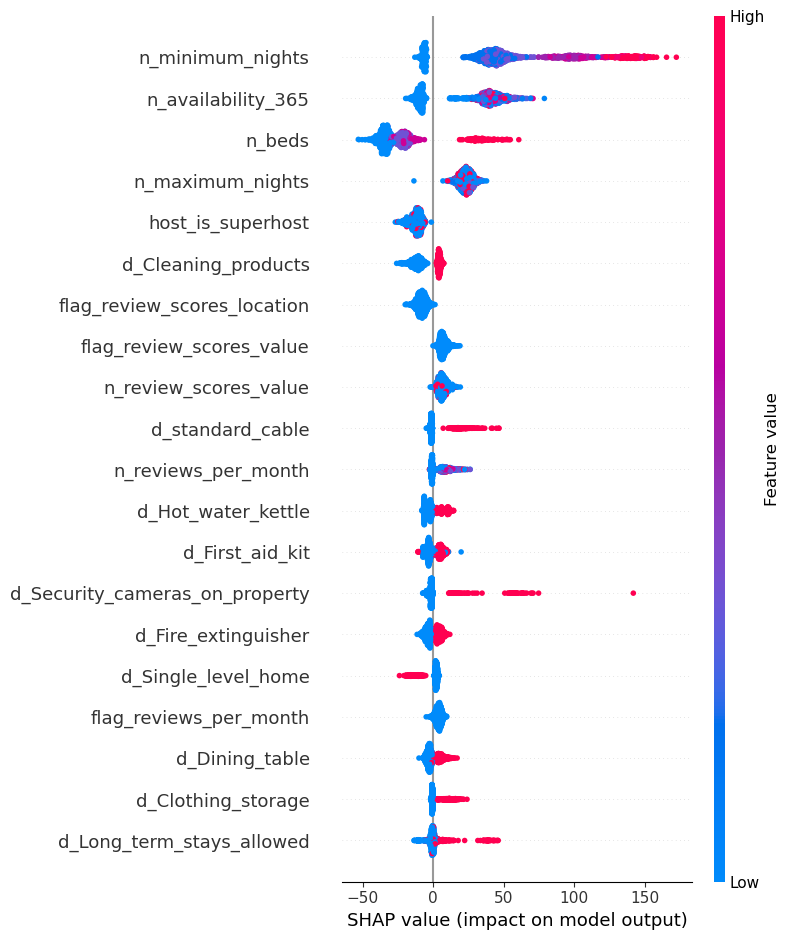

In [124]:
shap.summary_plot(shap_values, X_holdout, max_display=20, show= False)
plt.tight_layout()